In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from google.colab import files
from tensorflow import keras
from keras import backend as k
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data ()           #database loading

11490434/11490434 [==============================] - 0s 0us/step


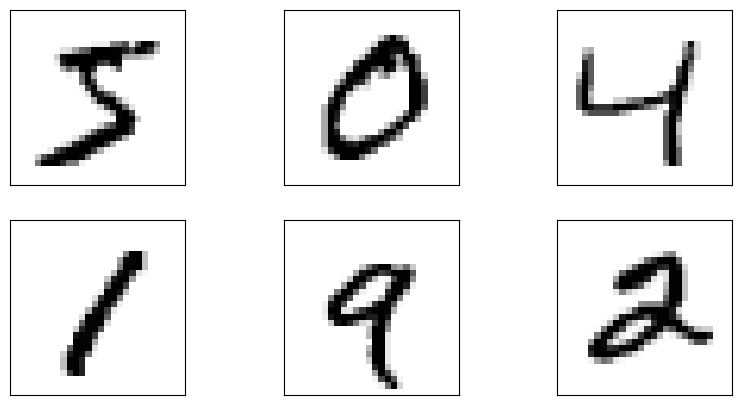

In [4]:
plt.figure(figsize=(10,5))
for i in range (6):
  plt.subplot(2,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i],cmap=plt.cm.binary)
plt.show()

In [5]:
x_train = x_train[y_train==5]                                      #select all "5" from the training sample
y_train = y_train[y_train==5]

BUFFER_SIZE = x_train.shape[0]                                     #determine the size of the buffer - how many "5" we got
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE               #determine a sample that is a multiple of 100
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]

print(x_train.shape, y_train.shape)

(5400, 28, 28) (5400,)


In [6]:
x_train = x_train/255                                             #standardization of input data
x_test = x_test/ 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)   #from them we form a tensor of real images, divided into batches

In [7]:
from tensorflow.python.ops.gen_batch_ops import Batch
#networking
hidden_dim = 2

def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

#generator
generator = tf.keras.Sequential([
    Dense(7*7*256, activation='relu', input_shape=(hidden_dim,)),                     #fully connected layer, the input is a vector of independent quantities hidden_dim
    BatchNormalization(),
    Reshape((7,7,256)),                                                               #is converted to a tensor with dimensions 7*7*256
    Conv2DTranspose(128, (5,5), strides=(1,1), padding = 'same', activation='relu'),  #First, a 7x7x256 tensor is transformed by a Conv2DTranspose layer with a 5x5 core and step (1, 1). At the output, we get the same dimensions 7x7, but 128 channels.
    BatchNormalization(),
    Conv2DTranspose(64, (5,5), strides=(2,2), padding = 'same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(1, (5,5), strides=(2,2), padding = 'same', activation='sigmoid'), #generated image
])

#discriminator
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,(5,5), strides = (2,2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

#losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)                 #binary cross entropy function

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output),(fake_output))                      #in binary cross-entropy we pass two parameters: the desired and real responses, For the generator, the desired discriminator response should be 1 for fake images
  return loss

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),(real_output))
  fake_loss = cross_entropy(tf.zeros_like(fake_output),(fake_output))                #For the discriminator, the desired discriminator response should be 1 for real images.
  total_loss = real_loss + fake_loss                   
  return total_loss

generator_optimizer = tf.keras.optimizers.Adam (1e-4)                                #optimizers for generator and discriminator
discriminator_optimizer = tf.keras.optimizers.Adam (1e-4)

In [8]:
from tensorflow.python.eager.backprop import GradientTape
#define the function of one training step through the decorator tf.function
@tf.function
def train_step(images):                                                              #At the input of the function, we supply a package (batch) of real images
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])                               #we also form one batch vector of normal random variables of length hidden_dim      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:              #feed into the generator
      generated_images = generator(noise, training = True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
 
    return gen_loss, disc_loss

In [9]:
#Let's declare a function that will run the entire process of learning networks. We will pass to its input a trained sample of images, divided into batches and the number of epochs:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)

  for epoch in range(1, epochs +1):
    print(f'{epoch}/{EPOCHS}: ', end='')
    start = time.time()                                                                 #measure the execution time of the epoch
    n=0

    gen_loss_epoch = 0
    for image_batch in dataset:                                                         #we skip the batch learning cycle by calling the train_step function
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += k.mean(gen_loss)                                                #we calculate the average losses for the generator by batches
      if (n % th == 0): print('=', end='')
      n+=1 

    history += [gen_loss_epoch / n]                                                     #save in history collection
    print(': '+ str(history[-1]))
    print('Time of epoch {} is {} sec.'.format(epoch, time.time()- start))

  return history                                                                        #return the loss history for the generator

1/20: ===========: tf.Tensor(1.4534158, shape=(), dtype=float32)
Time of epoch 1 is 76.72128868103027 sec.
2/20: ===========: tf.Tensor(2.279167, shape=(), dtype=float32)
Time of epoch 2 is 69.5065848827362 sec.
3/20: ===========: tf.Tensor(3.2475717, shape=(), dtype=float32)
Time of epoch 3 is 68.48987913131714 sec.
4/20: ===========: tf.Tensor(3.3209658, shape=(), dtype=float32)
Time of epoch 4 is 70.67840766906738 sec.
5/20: ===========: tf.Tensor(3.013753, shape=(), dtype=float32)
Time of epoch 5 is 68.35006666183472 sec.
6/20: ===========: tf.Tensor(3.14812, shape=(), dtype=float32)
Time of epoch 6 is 68.3428122997284 sec.
7/20: ===========: tf.Tensor(2.9833508, shape=(), dtype=float32)
Time of epoch 7 is 68.64068698883057 sec.
8/20: ===========: tf.Tensor(1.5546823, shape=(), dtype=float32)
Time of epoch 8 is 69.76167321205139 sec.
9/20: ===========: tf.Tensor(1.3841166, shape=(), dtype=float32)
Time of epoch 9 is 68.4971387386322 sec.
10/20: ===========: tf.Tensor(1.3182006, sha

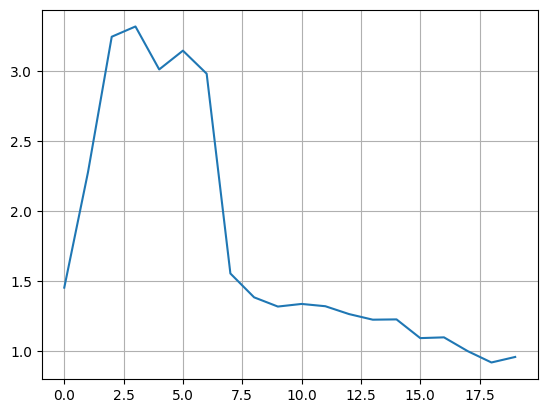

In [10]:
#we start the learning process and display a graph of the change in losses for the generator by epochs:
EPOCHS = 20
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid('True')
plt.show()

1/1 [==============================] - 0s 29ms/step


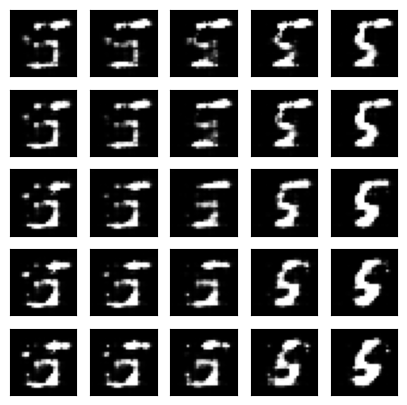

In [11]:
#display of generation results
n = 2
total = 2*n+1
 
plt.figure(figsize=(total, total))
 
num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
    plt.imshow(img[0,:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)